In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
import pyspark.pandas.plot.matplotlib as plt
import pandas as pd
spark = SparkSession.builder\
.master("local[4]")\
.appName("DataExplore")\
.config("spak.executer.memory", "4g")\
.config("spark.driver.memory", "2g")\
.getOrCreate()

In [2]:
adultTrain = spark.read\
.option("header", "True")\
.option("inferSchema", "True")\
.option("sep", ",")\
.csv("adult_data")

In [3]:
adultTest = spark.read\
.option("header", "True")\
.option("inferSchema", "True")\
.option("sep", ",")\
.csv("adult_test")

In [4]:
adultTrain.show(5)

+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|output|
+---+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
| 38|          Private|215646.0|   HS-grad|       

<font color='blue'> Since dataFrame is too much big I colud not show it properly. I will transform to pandas dataFrame and show with head method </font>

In [5]:
adultTrain.limit(5).toPandas().head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,output
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [6]:
adultTest.limit(5).toPandas().head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [7]:
adultDF = adultTrain.union(adultTest)

In [8]:
adultDF.limit(5).toPandas().head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,output
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


print("Size of trian dataFrame", adultTrain.count())
print("Size of test dataFrame", adultTest.count())
print("Size of adult dataFrame", adultDF.count())

32561 + 16281 = 48842

# Schema of dataFrame

In [9]:
adultDF.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- output: string (nullable = true)



# <font color='red'> Statical description of numeric features </font>

In [10]:
adultDF.describe(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']).toPandas()

,summary,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,count,48842,48842,48842,48842,48842,48842
1,mean,38.64358543876172,189664.13459727284,10.078088530363212,1079.0676262233324,87.50231358257237,40.422382375824085
2,stddev,13.710509934443563,105604.02542315733,2.570972755592263,7452.019057655401,403.0045521243599,12.3914440242523
3,min,17,12285.0,1.0,0.0,0.0,1.0
4,max,90,1490400.0,16.0,99999.0,4356.0,99.0


<font color='blue'>You can see some statical results on dataFrame. Since dataFrame is on the adult population, it is expected that min of age is 17. Min working hour is 1 and max is 99, presumably, these two data point is an outlier. Avg work hour per week is 40 as expected. I will talk about other features in later chapters. </font>

# <font color='red'> Statical description of categorical features </font>

# 1. Workclass

In [12]:
adultDF.groupBy(F.col('workclass'))\
.agg({"*": "count"}).toPandas()

,workclass,count(1)
0,State-gov,1981
1,Federal-gov,1432
2,Self-emp-not-inc,3862
3,Local-gov,3136
4,Private,33906
5,?,2799
6,Self-emp-inc,1695
7,Without-pay,21
8,Never-worked,10


In [13]:
adultDF.createOrReplaceTempView("workclass_tbl")

In [14]:
spark.sql("SELECT workclass, COUNT(*) FROM workclass_tbl GROUP BY workclass").toPandas()

,workclass,count(1)
0,State-gov,1981
1,Federal-gov,1432
2,Self-emp-not-inc,3862
3,Local-gov,3136
4,Private,33906
5,?,2799
6,Self-emp-inc,1695
7,Without-pay,21
8,Never-worked,10


# 2. Education

In [15]:
adultDF.createOrReplaceTempView("eduTBL")
spark.sql("SELECT education, COUNT(*) FROM eduTBL GROUP BY education").toPandas()

,education,count(1)
0,Prof-school,834
1,10th,1389
2,7th-8th,955
3,5th-6th,509
4,Assoc-acdm,1601
5,Assoc-voc,2061
6,Masters,2657
7,12th,657
8,Preschool,83
9,9th,756


<font color='blue'> There is too much category, I will reduce it.  
2 + 3 + 8 => elemnetary school  
1 + 7 + 9 => high school  
4 + 5 + 6 => high education
</font>

# 3. marital status

In [16]:
adultDF.createOrReplaceTempView("maritalTBL")
spark.sql("SELECT marital_status, COUNT(*) FROM maritalTBL GROUP BY marital_status").toPandas()

,marital_status,count(1)
0,Widowed,1518
1,Married-spouse-absent,628
2,Married-AF-spouse,37
3,Married-civ-spouse,22379
4,Divorced,6633
5,Never-married,16117
6,Separated,1530


no problem

# 4. occupation

In [17]:
adultDF.createOrReplaceTempView("occupationTBL")
spark.sql("SELECT occupation, COUNT(*) FROM occupationTBL GROUP BY occupation").toPandas()

,occupation,count(1)
0,Farming-fishing,1490
1,Handlers-cleaners,2072
2,Prof-specialty,6172
3,Adm-clerical,5611
4,Exec-managerial,6086
5,Craft-repair,6112
6,Sales,5504
7,?,2809
8,Tech-support,1446
9,Transport-moving,2355


<font color='blue'> drop ?
</font>

# 5.relationship

adultDF.createOrReplaceTempView("relationshipTBL")
spark.sql("SELECT relationship, COUNT(*) FROM relationshipTBL GROUP BY relationship").toPandas()

# 6. Race

In [18]:
adultDF.createOrReplaceTempView("RaceTBL")
spark.sql("SELECT Race, COUNT(*) FROM RaceTBL GROUP BY Race").toPandas()

,Race,count(1)
0,Asian-Pac-Islander,1519
1,Black,4685
2,Other,406
3,White,41762
4,Amer-Indian-Eskimo,470


# 7. sex

In [19]:
adultDF.createOrReplaceTempView("sexTBL")
spark.sql("SELECT sex, COUNT(*) FROM sexTBL GROUP BY sex").toPandas()

,sex,count(1)
0,Male,32650
1,Female,16192


# 8. native country


<font color='blue'> drop ?
</font>

# 9. output

In [20]:
adultDF.createOrReplaceTempView("outputTBL")
spark.sql("SELECT output, COUNT(*) FROM outputTBL GROUP BY output").toPandas()

,output,count(1)
0,>50K,7841
1,<=50K,24720
2,>50K.,3846
3,<=50K.,12435



<font color='blue'> clear the "."
</font>

## <font color='red'>  DATA CLEANING
</font>

# <font color='blue'> 1. apply trim
</font>

In [21]:
adultDF = adultDF \
.withColumn("workclass", trim(col("workclass"))) \
.withColumn("education", trim(col("education"))) \
.withColumn("marital_status", trim(col("marital_status"))) \
.withColumn("occupation", trim(col("occupation"))) \
.withColumn("relationship", trim(col("relationship"))) \
.withColumn("race", trim(col("race"))) \
.withColumn("sex", trim(col("sex"))) \
.withColumn("native_country", trim(col("native_country"))) \
.withColumn("output", trim(col("output")))

# <font color='blue'> 2. clear "." from output
</font>

In [22]:
adultDF = adultDF \
.withColumn("output", regexp_replace(col("output"), "<=50K.", "<=50K")) \
.withColumn("output", regexp_replace(col("output"), ">50K.", ">50K"))


## <font color='blue'> 3. Nulls
</font>

In [23]:
adultDF.columns

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'output']

In [24]:
counter = 0

for i in adultDF.columns:
    if(adultDF.filter(col(i).isNull()).count() > 0):
        print(counter, " , ", i, " contains null")
    else:
        print(counter, i)
    counter += 1

0 age
1 workclass
2 fnlwgt
3 education
4 education_num
5 marital_status
6 occupation
7 relationship
8 race
9 sex
10 capital_gain
11 capital_loss
12 hours_per_week
13 native_country
14 output


<font color='blue'> there is no null value
</font>


## <font color='blue'> 4. Check ?
</font>

In [25]:
counter = 0

for i in adultDF.columns:
    if(adultDF.filter(col(i).contains("?")).count() > 0):
        print(counter, ".", i, " contains ?")
    else:
        print(counter, i)
    counter += 1

0 age
1 . workclass  contains ?
2 fnlwgt
3 education
4 education_num
5 marital_status
6 . occupation  contains ?
7 relationship
8 race
9 sex
10 capital_gain
11 capital_loss
12 hours_per_week
13 . native_country  contains ?
14 output


In [26]:
adultDF.select("workclass", "occupation", "native_country", "output") \
.filter(col("workclass").contains("?") | col("occupation").contains("?") | col("native_country").contains("?")) \
.groupBy("workclass", "occupation", "native_country", "output").count() \
.orderBy(col("count").desc()) \
.toPandas()

,workclass,occupation,native_country,output,count
0,?,?,United-States,<=50K,2284
1,?,?,United-States,>50K,246
2,Private,Other-service,?,<=50K,100
3,Private,Sales,?,<=50K,55
4,Private,Prof-specialty,?,<=50K,51
...,...,...,...,...,...
132,State-gov,Farming-fishing,?,<=50K,1
133,Local-gov,Adm-clerical,?,>50K,1
134,Federal-gov,Armed-Forces,?,>50K,1
135,State-gov,Transport-moving,?,<=50K,1


<font color='blue'> values which are contains ? look like random and there is only 137 of them so i will drop it.
</font>

In [27]:
adultDF = adultDF.filter(~(col("workclass").contains("?") | col("occupation").contains("?") | col("native_country").contains("?")))
adultDF.count()

45222

In [28]:
adultDF = adultDF.filter(~(col("workclass").contains("never-worked") | col("workclass").contains("without-pay") | 
                           col("occupation").contains("Armed-Forces") | col("native_country").contains("Holand-Netherlands")))

In [29]:
adultDF.count()

45207


## <font color='blue'> 5. Reduce education classes
</font>

In [30]:
adultDF = adultDF.withColumn("educationMerged", 
when(col("education").isin("1st-4th", "5th-6th", "7th-8th"), "Elementary-School")
.when(col("education").isin("9th", "11th", "12th", "10th"), "High-School")
.when(col("education").isin("Masters", "Doctorate"), "postgraduate")
.when(col("education").isin("Bachelors", "Some-college"), "Undergarduate")
.otherwise(col("education"))                      
)

adultDF.select("education", "educationMerged").toPandas()

,education,educationMerged
0,Bachelors,Undergarduate
1,Bachelors,Undergarduate
2,HS-grad,HS-grad
3,11th,High-School
4,Bachelors,Undergarduate
...,...,...
45202,Bachelors,Undergarduate
45203,Bachelors,Undergarduate
45204,Bachelors,Undergarduate
45205,Bachelors,Undergarduate


In [31]:
adultDF.toPandas().head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,output,educationMerged
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,Undergarduate
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,Undergarduate
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,HS-grad
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,High-School
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,Undergarduate


In [32]:
orderedFeature = ["workclass", "education", "educationMerged", "marital_status", "occupation", "relationship", "race",
                    "sex", "native_country", "age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week",
                    "output"]

adultDF = adultDF.select(orderedFeature)
adultDF.toPandas().head()

,workclass,education,educationMerged,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,output
0,State-gov,Bachelors,Undergarduate,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,77516.0,13.0,2174.0,0.0,40.0,<=50K
1,Self-emp-not-inc,Bachelors,Undergarduate,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,83311.0,13.0,0.0,0.0,13.0,<=50K
2,Private,HS-grad,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,215646.0,9.0,0.0,0.0,40.0,<=50K
3,Private,11th,High-School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,234721.0,7.0,0.0,0.0,40.0,<=50K
4,Private,Bachelors,Undergarduate,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,338409.0,13.0,0.0,0.0,40.0,<=50K


with open('CleanedAdult.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(adultDF.columns)

    # write multiple rows
    writer.writerows(adultDF.toPandas().values)

# <font color='red'> Preprocessing part 2 </font>

## <font color='red'> 1. StringIndexer </font>

In [33]:
adultDF.toPandas().head()

,workclass,education,educationMerged,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,output
0,State-gov,Bachelors,Undergarduate,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,77516.0,13.0,2174.0,0.0,40.0,<=50K
1,Self-emp-not-inc,Bachelors,Undergarduate,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,83311.0,13.0,0.0,0.0,13.0,<=50K
2,Private,HS-grad,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,215646.0,9.0,0.0,0.0,40.0,<=50K
3,Private,11th,High-School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,234721.0,7.0,0.0,0.0,40.0,<=50K
4,Private,Bachelors,Undergarduate,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,338409.0,13.0,0.0,0.0,40.0,<=50K


In [34]:
educationIndexer = StringIndexer().setInputCol("educationMerged").setOutputCol("educationIndexer")

In [35]:
educationIndexerModel = educationIndexer.fit(adultDF)
adultDF = educationIndexerModel.transform(adultDF)
adultDF.toPandas().head()

,workclass,education,educationMerged,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,output,educationIndexer
0,State-gov,Bachelors,Undergarduate,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,77516.0,13.0,2174.0,0.0,40.0,<=50K,0.0
1,Self-emp-not-inc,Bachelors,Undergarduate,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,83311.0,13.0,0.0,0.0,13.0,<=50K,0.0
2,Private,HS-grad,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,215646.0,9.0,0.0,0.0,40.0,<=50K,1.0
3,Private,11th,High-School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,234721.0,7.0,0.0,0.0,40.0,<=50K,2.0
4,Private,Bachelors,Undergarduate,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,338409.0,13.0,0.0,0.0,40.0,<=50K,0.0


<font color='blue'>  it gives least index to most repeated value</font>

In [36]:
adultDF.groupBy(col("educationMerged")).agg(count("*").alias("count")).sort(desc("count")).toPandas().head()

,educationMerged,count
0,Undergarduate,17463
1,HS-grad,14778
2,High-School,4094
3,postgraduate,3056
4,Assoc-voc,1959


## <font color='red'> 2. OneHotEncoder </font>

In [37]:
encoder = OneHotEncoder().setInputCol("educationIndexer").setOutputCol("EducationEncoded")
encoderModel = encoder.fit(adultDF)
adultDF = encoderModel.transform(adultDF)
adultDF.toPandas().head()

,workclass,education,educationMerged,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,output,educationIndexer,EducationEncoded
0,State-gov,Bachelors,Undergarduate,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,77516.0,13.0,2174.0,0.0,40.0,<=50K,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,Self-emp-not-inc,Bachelors,Undergarduate,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,83311.0,13.0,0.0,0.0,13.0,<=50K,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,Private,HS-grad,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,215646.0,9.0,0.0,0.0,40.0,<=50K,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,Private,11th,High-School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,234721.0,7.0,0.0,0.0,40.0,<=50K,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,Private,Bachelors,Undergarduate,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,338409.0,13.0,0.0,0.0,40.0,<=50K,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


## <font color='red'> Convert whole categorical  feature to numeric feature with OneHotEncoder</font>

In [38]:
Indexer = StringIndexer().setInputCols(["workclass", "marital_status", "occupation", "relationship", "race", "sex", 
                                        "native_country", "output"])\
.setOutputCols(["workclassIndex", "marital_statusIndex", "occupationIndex", "relationshipIndex", "raceIndex", 
                "sexIndex", "native_countryIndex", "label"])
IndexerModel = Indexer.fit(adultDF)
adultDF = IndexerModel.transform(adultDF)
adultDF.toPandas().head()

,workclass,education,educationMerged,marital_status,occupation,relationship,race,sex,native_country,age,...,educationIndexer,EducationEncoded,workclassIndex,marital_statusIndex,occupationIndex,relationshipIndex,raceIndex,sexIndex,native_countryIndex,label
0,State-gov,Bachelors,Undergarduate,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0
1,Self-emp-not-inc,Bachelors,Undergarduate,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,Private,HS-grad,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,...,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,2.0,8.0,1.0,0.0,0.0,0.0,0.0
3,Private,11th,High-School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,...,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,0.0,8.0,0.0,1.0,0.0,0.0,0.0
4,Private,Bachelors,Undergarduate,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,0.0,1.0,4.0,1.0,1.0,8.0,0.0


In [39]:
encoder = OneHotEncoder().setInputCols(["workclassIndex", "marital_statusIndex", "occupationIndex", "relationshipIndex", 
                                        "raceIndex", "sexIndex", "native_countryIndex"])\
.setOutputCols(["workclassEncoded", "marital_statusEncoded", "occupationEncoded", "relationshipEncoded", "raceEncoded", 
                "sexEncoded", "native_countryEncoded"])
encoderModel = encoder.fit(adultDF)
adultDF = encoderModel.transform(adultDF)
adultDF.toPandas().head()

,workclass,education,educationMerged,marital_status,occupation,relationship,race,sex,native_country,age,...,sexIndex,native_countryIndex,label,workclassEncoded,marital_statusEncoded,occupationEncoded,relationshipEncoded,raceEncoded,sexEncoded,native_countryEncoded
0,State-gov,Bachelors,Undergarduate,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,...,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Self-emp-not-inc,Bachelors,Undergarduate,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,...,0.0,0.0,0.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Private,HS-grad,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,...,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Private,11th,High-School,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,...,0.0,0.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)",(1.0),"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Private,Bachelors,Undergarduate,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,...,1.0,8.0,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 1.0, 0.0, 0.0)",(0.0),"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


## <font color='red'> 3. VectorAssembler</font>

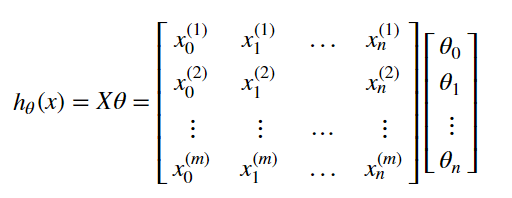

In [40]:
from IPython.display import Image
Image(filename='vectorizedFeatures.png')

In [41]:
assembler = VectorAssembler().setInputCols(["age", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week", "EducationEncoded",
                                       "workclassEncoded", "marital_statusEncoded", "occupationEncoded", "relationshipEncoded", 
                                        "raceEncoded", "sexEncoded", "native_countryEncoded"])\
.setOutputCol("vectorizedFeatures")

assemblerAdultDF = assembler.transform(adultDF)

In [42]:
pd.set_option('display.max_colwidth', None)

In [43]:
assemblerAdultDF.select("vectorizedFeatures").toPandas().head()

,vectorizedFeatures
0,"(39.0, 77516.0, 2174.0, 0.0, 40.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,"(50.0, 83311.0, 0.0, 0.0, 13.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,"(38.0, 215646.0, 0.0, 0.0, 40.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,"(53.0, 234721.0, 0.0, 0.0, 40.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,"(28.0, 338409.0, 0.0, 0.0, 40.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


## <font color='red'> 4. StandardScaler </font>

In [44]:
scaler = StandardScaler().setInputCol("vectorizedFeatures").setOutputCol("features")
scalerModel = scaler.fit(assemblerAdultDF)
scaledDF = scalerModel.transform(assemblerAdultDF)
scaledDF.select("features").toPandas().head()

,features
0,"(2.9504215419642694, 0.7337346424147725, 0.28957347319637977, 0.0, 3.331135935825709, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.926984421608854, 0.0, 0.0, 0.0, 2.138945468917177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0495188603896026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2833707070858567, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
1,"(3.7825917204670123, 0.7885877340706062, 0.0, 0.0, 1.0826191791433555, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.6056197442060847, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9507654365061002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,"(2.8747697075549294, 2.041216532047268, 0.0, 0.0, 3.331135935825709, 0.0, 2.13181352367185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8880414502182474, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.810634043094, 0.0, 0.0, 0.0, 0.0, 2.2833707070858567, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
3,"(4.009547223695033, 2.2217726534165565, 0.0, 0.0, 3.331135935825709, 0.0, 0.0, 3.484475224023051, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.810634043094, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 0.0, 3.4347788751308443, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
4,"(2.118251363461527, 3.203240706498539, 0.0, 0.0, 3.331135935825709, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9457672408537485, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.761070760185801, 0.0, 3.4347788751308443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.46341423896605, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"


## <font color='red'> 5. Train Test Split </font>

In [46]:
df_train, df_test = scaledDF.select("features", "label").randomSplit([0.5,0.5])
df_train.toPandas().head()

,features,label
0,"(1.8912958602335062, 0.9853394792230065, 0.37681847087054204, 0.0, 4.996703903738564, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
1,"(1.9669476946428464, 1.7244221797543529, 0.37681847087054204, 0.0, 3.331135935825709, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
2,"(2.0425995290521866, 3.3947011870718864, 0.37681847087054204, 0.0, 5.829487887694991, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
3,"(2.3452068666895474, 2.0004009097487425, 0.3206087166438299, 0.0, 5.413095895716777, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0
4,"(2.496510535508228, 1.8742151349663578, 0.9720824321008187, 0.0, 4.163919919782137, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0


In [47]:
df_train.select("features")

DataFrame[features: vector]

## <font color='red'> 6. ML Model </font>

In [101]:
def metrices(df):
    tp = df.select("label", "predictions", "probability").where("predictions == 1 and label == 1").count()
    tn = df.select("label", "predictions", "probability").where("predictions == 0 and label == 0").count()
    fp = df.select("label", "predictions", "probability").where("predictions == 1 and label == 0").count()
    fn = df.select("label", "predictions", "probability").where("predictions == 0 and label == 1").count()
    
    accuracy = float((tp+tn)/(tp+tn+fp+fn))
    recall = float(tp/(tp+fn))
    precision = float(tp/(tp+fp))
    print("accuracy: " , accuracy , "\n" , "recall: " , recall , "\n" , "precision: " , precision)
    return accuracy

### <font color='blue'> 6.A LogisticRegression  </font>

In [50]:
lrObject = LogisticRegression().setFeaturesCol("features").setLabelCol("label").setPredictionCol("predictions")

In [54]:
transformedDF.toPandas().head()

,features,label,rawPrediction,probability,predictions
0,"(1.6643403570054853, 1.807624712222822, 0.3206087166438299, 0.0, 3.331135935825709, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"[0.12969730857816586, -0.12969730857816586]","[0.5323789516116045, 0.46762104838839547]",0.0
1,"(1.8156440258241657, 0.3960213371349044, 0.3206087166438299, 0.0, 3.331135935825709, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"[0.1930163139940948, -0.1930163139940948]","[0.5481048245199674, 0.45189517548003255]",0.0
2,"(2.193903197870867, 1.262898962678401, 0.6677239287642374, 0.0, 3.331135935825709, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"[-0.804003614054789, 0.804003614054789]","[0.30916975902569627, 0.6908302409743037]",1.0
3,"(2.193903197870867, 2.209467386953643, 0.4543399802543015, 0.0, 3.747527927803923, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",0.0,"[-0.5275855536273077, 0.5275855536273077]","[0.37108019514966606, 0.6289198048503339]",1.0
4,"(2.3452068666895474, 2.2790394704170387, 0.5842084882425583, 0.0, 4.163919919782137, 2.053794181978513, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.2706380838018303, 0.0, 0.0, 0.0, 0.0, 0.0, 2.004724332188047, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9432803437120345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0311120498508806, 0.0, 0.0, 0.0, 0.0, 2.8842073159551096, 0.0, 0.0, 0.0, 2.1349534581741607, 3.5497727106407595, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)",1.0,"[-1.0228474173861866, 1.0228474173861866]","[0.26447312936243916, 0.7355268706375608]",1.0


In [53]:
lrModel = lrObject.fit(df_train)
transformedDF = lrModel.transform(df_test)
transformedDF.select("label", "predictions").toPandas().head()

,label,predictions
0,0.0,0.0
1,0.0,0.0
2,0.0,1.0
3,0.0,1.0
4,1.0,1.0


In [67]:
metrices(transformedDF)

accuracy:  0.8471160220994475 
 recall:  0.6109025915996426 
 precision:  0.7272340425531915


### <font color='blue'> 6.B DecisionTreeClassifier  </font>

In [102]:
acc = []

for i in range(2,20,1):
    dtObject = DecisionTreeClassifier(maxDepth=i, labelCol="label", featuresCol="features", predictionCol="predictions")
    dtModel = dtObject.fit(df_train)
    transformedDF = dtModel.transform(df_test)
    print("Decision Tree with ", i, " max depth\n")
    acc.append(metrices(transformedDF))
    print("-------------------------------\n")

Decision Tree with  2  max depth

accuracy:  0.7877127071823204 
 recall:  0.142627345844504 
 precision:  0.9925373134328358
-------------------------------

Decision Tree with  3  max depth

accuracy:  0.8037127071823205 
 recall:  0.2223413762287757 
 precision:  0.9325337331334332
-------------------------------

Decision Tree with  4  max depth

accuracy:  0.8167955801104972 
 recall:  0.3079535299374441 
 precision:  0.8632264529058116
-------------------------------

Decision Tree with  5  max depth

accuracy:  0.817414364640884 
 recall:  0.6210902591599643 
 precision:  0.6334305504921619
-------------------------------

Decision Tree with  6  max depth

accuracy:  0.8285966850828729 
 recall:  0.620017873100983 
 precision:  0.6644321011300517
-------------------------------

Decision Tree with  7  max depth

accuracy:  0.8281546961325967 
 recall:  0.6223413762287757 
 precision:  0.6623549552976983
-------------------------------

Decision Tree with  8  max depth

accuracy:

In [103]:
acc

[0.7877127071823204,
 0.8037127071823205,
 0.8167955801104972,
 0.817414364640884,
 0.8285966850828729,
 0.8281546961325967,
 0.8296132596685083,
 0.8332817679558011,
 0.8334585635359116,
 0.8326187845303867,
 0.8343425414364641,
 0.8337237569060774,
 0.830939226519337,
 0.8280220994475138,
 0.8262099447513812,
 0.8247071823204419,
 0.8235580110497237,
 0.8198453038674033]

In [116]:
df = pd.DataFrame(acc, columns=["acc"])
df["index"] = range(2,20,1)
df.columns


Index(['acc', 'index'], dtype='object')

<AxesSubplot:xlabel='index'>

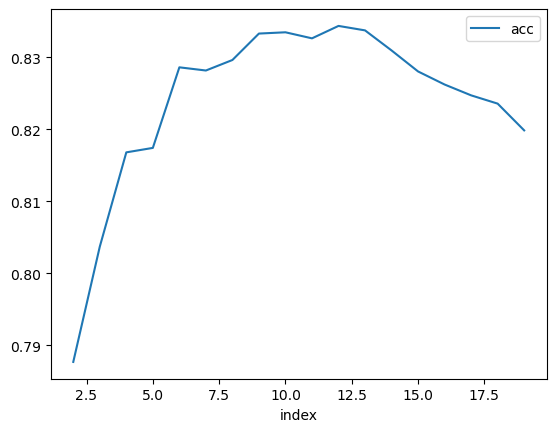

In [118]:
df.plot.line(x = "index", y = "acc")

In [119]:
dtObject = DecisionTreeClassifier(maxDepth=6, labelCol="label", featuresCol="features", predictionCol="predictions")
dtModel = dtObject.fit(df_train)
transformedDF = dtModel.transform(df_test)
metrices(transformedDF)

accuracy:  0.8285966850828729 
 recall:  0.620017873100983 
 precision:  0.6644321011300517


0.8285966850828729